# Definindo Regex para identificar as informações relevantes

In [1]:
%pip ins'tall ipywidgets

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "ins'tall" - maybe you meant "install"



In [2]:
import re

## Exemplos de texto que podem ser fornecidos

In [3]:
texto_1 = '''
VALIDO EM TODO TERRITORIO NACIONAL
07.116.299-9 expevis 20/09/1976
NOME
SANDLER CAFFARO
FILIACAO
GABRIELA AUDI LUCARELLI
NATURALIDADE N DATA DE NASCIMENTO
BORBA-AM É Do 20/08/1999
Doc ongem C.NAS=116 LV=291 FL=Sd3
CURITIBA-PR
CPF 025.762.835-51 71695/9247

TONELOTITEYTAN ROSANTE
NH 94 ASSINATURA DO DIRETOR
'''

In [4]:
%matplotlib inline

import pytesseract
import cv2

import pandas as pd
from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [5]:
img_path = "../../BID Dataset/RG_Verso/00025928_in.jpg"

In [6]:
image = cv2.imread(img_path)

In [7]:
df = pytesseract.image_to_data(image, lang='por', output_type='data.frame')

## Criando e testando Regex/ identificação de padrões

In [8]:
def create_info_dict_from_row(row, name):
    return {
        'left': row['left'],
        'top': row['top'],
        'width': row['width'],
        'height': row['height'],
        'name': name
    }

### Identificação CPF

In [9]:
cpf_regex = r'^\d{3}[\,\.]?\d{3}[\,\.]?\d{3}[\,\.\-\/]?\d{2}$'

def find_cpf(identified_texts_df):
    for i, row in identified_texts_df.iterrows():
        if is_cpf(row['text']):
            return format_cpf(row['text']), create_info_dict_from_row(row, 'cpf')
    return False

def is_cpf(text):
    if not isinstance(text, str):
        return False
    return bool(re.search(cpf_regex, text))

def format_cpf(unformated_cpf):
    # Remove todas pontuações da regex, mantendo apenas os digitos
    cpf = re.sub(r'[\-\,\.\/]', '', unformated_cpf)
    # Retorna o CPF com o seu padrão correto
    return f'{cpf[0:3]}.{cpf[3:6]}.{cpf[6:9]}-{cpf[9:11]}'
    

In [10]:
print(is_cpf('123.456.789-10'))

True


In [11]:
find_cpf(df)

('025.762.835-51',
 {'left': 115, 'top': 407, 'width': 133, 'height': 14, 'name': 'cpf'})

### Identificação RG

In [12]:
rg_regex = r'^\d{2}[\,\.]?\d{3}[\,\.]?\d{3}[\,\.\-]?\d$'

def find_rg(identified_texts_df):
    for i, row in identified_texts_df.iterrows():
        if is_rg(row['text']):
            return format_rg(row['text']), create_info_dict_from_row(row, 'rg')
    return False
    

def is_rg(text):
    if not isinstance(text, str):
        return False
    return bool(re.search(rg_regex, text))

def format_rg(unformated_rg):
    # Remove todas pontuações da regex, mantendo apenas os digitos
    rg = re.sub(r'[\-\,\.]', '', unformated_rg)
    # Retorna o RG com o seu padrão correto
    return f'{rg[0:2]}.{rg[2:5]}.{rg[5:8]}-{rg[8:9]}'

### Identificação data de nascimento

In [13]:
date_regex = r'^\d{2}[\/]?\d{2}[\/]?\d{4}$'

def find_birthdate(identified_texts_df):
    dates_count = 0
    for i, row in identified_texts_df.iterrows():
        if is_date(row['text']):
            dates_count += 1
        if dates_count == 2:
            return format_date(row['text']), create_info_dict_from_row(row, 'data\nde\nnasc.')
    return False

def is_date(text):
    if not isinstance(text, str):
        return False
    return bool(re.search(date_regex, text))

def format_date(unformated_date):
    # Remove todas pontuações da regex, mantendo apenas os digitos
    date = re.sub(r'[\/]', '', unformated_date)
    # Retorna a data formatada com o seu padrão correto
    return {
        'formated_date': f'{date[0:2]}/{date[3:4]}/{date[5:]}',
        'day': int(date[0:1]),
        'month': int(date[2:3]),
        'year': int(date[4:])
    }

### Identificação nome

In [14]:
def find_name(identified_texts_df):
    nome_found = False

    name = ''
    info_dict = {
        'left': None,
        'right': None,
        'width': 0,
        'height': 0,
        'name': 'nome'
    }
    space_width = 6
    for i, row in identified_texts_df.iterrows():
        if isinstance(row['text'], str):
            if row['text'].lower() == 'filiação' or row['text'].lower() == 'filiacao':
                info_dict['width'] -= space_width
                return format_name(name), info_dict

            if nome_found:
                name += row['text'] + ' '
                if info_dict['left'] is None:
                    info_dict['left'] = row['left']
                    info_dict['top'] = row['top']
                    info_dict['height'] = row['height']
                info_dict['width'] += row['width'] + space_width
            
            if row['text'].lower() == 'nome':
                nome_found = True
    return False

def format_name(text):
    if not isinstance(text, str):
        return False
    return text.strip().title()

## Teste camera

In [15]:
# init camera
camera = cv2.VideoCapture(0)

In [16]:
ret, frame = camera.read()

In [17]:
# show camera frame
from time import sleep
from IPython.display import display, Image

display_handle=display(None, display_id=True)
for i in range(10):
    ret, frame = camera.read()
    _, frame = cv2.imencode('.jpeg', frame)
    display_handle.update(Image(data=frame.tobytes()))

None

In [18]:
camera.release()
display_handle.update(None)

## Codigo geral

In [19]:
def get_document_info(document_image):
    document_dict = {}
    document_bounding_boxes = []

    identified_texts_df = pytesseract.image_to_data(document_image, lang='por', output_type='data.frame')

    name_response = find_name(identified_texts_df)
    if name_response:
        document_dict['nome'] = name_response[0]
        document_bounding_boxes.append(name_response[1])

    cpf_response = find_cpf(identified_texts_df)
    if cpf_response:
        document_dict['cpf'] = cpf_response[0]
        document_bounding_boxes.append(cpf_response[1])
    
    name_response = find_name(identified_texts_df)
    if name_response:
        document_dict['nome'] = name_response[0]
        document_bounding_boxes.append(name_response[1])
    
    rg_response = find_rg(identified_texts_df)
    if rg_response:
        document_dict['rg'] = rg_response[0]
        document_bounding_boxes.append(rg_response[1])
    
    birthdate_response = find_birthdate(identified_texts_df)
    if birthdate_response:
        document_dict['data de nascimento'] = birthdate_response[0]
        document_bounding_boxes.append(birthdate_response[1])
    
    return document_dict, pd.DataFrame(document_bounding_boxes)

In [20]:
def add_bounding_boxes(document_image, bounding_boxes, padding=5, color=(0, 255, 0)):
    for i, row in bounding_boxes.iterrows():
        (x, y, w, h) = (row['left'], row['top'], row['width'], row['height'])

        x -= padding
        y -= padding
        w += padding * 2
        h += padding * 2

        cv2.rectangle(
            img=document_image, 
            pt1=(x, y),
            pt2=(x + w, y + h), 
            color=color, 
            thickness=2
        )
        cv2.putText(
            img=document_image,
            text=row['name'], 
            org=(x + w + 10, y + h), 
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=1.5,
            color=color,
            thickness=2,
            lineType=2
        )
    return document_image

In [21]:
document_dict, document_bounding_boxes = get_document_info(image)
print(document_dict)
print(document_bounding_boxes)

{'nome': 'Sandler Caffaro', 'cpf': '025.762.835-51', 'rg': '07.116.299-9'}
   left  right  width  height  name  top
0    76    NaN    233      18  nome  144
1   115    NaN    133      14   cpf  407
2    76    NaN    233      18  nome  144
3   155    NaN    147      19    rg   77


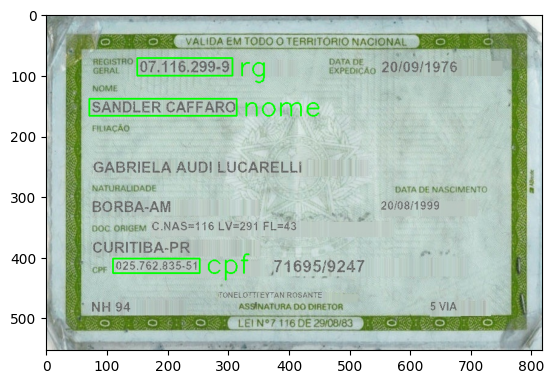

In [22]:
add_bounding_boxes(image, document_bounding_boxes)
plt.imshow(image)
plt.show()

## Detecção em tempo real

In [23]:
def all_info_collected(document_dict):
    necessary_keys = ['cpf', 'rg', 'data de nascimento', 'nome']
    document_keys = list(document_dict.keys())
    for necessary_key in necessary_keys:
        if necessary_key not in document_keys:
            return False
    return True

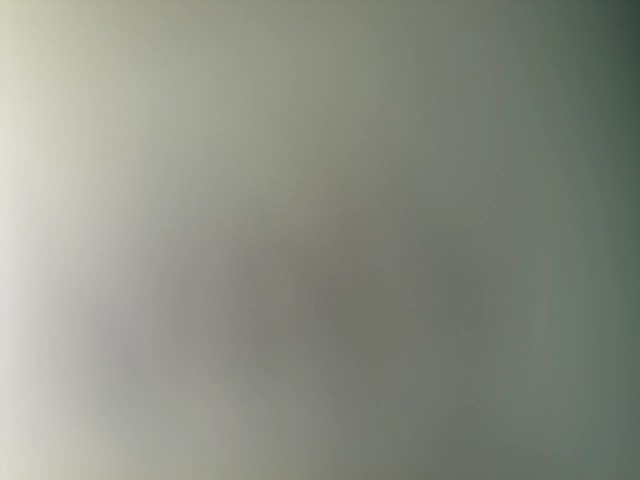

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [24]:
camera = cv2.VideoCapture(0)

display_handle = display(None, display_id=True)
document_dict = {}
document_bounding_boxes = None

while not all_info_collected(document_dict):
    ret, frame = camera.read()

    document_dict, document_bounding_boxes = get_document_info(frame)

    # frame = cv2.flip(frame, 1) # if your camera reverses your image
    frame = add_bounding_boxes(frame, document_bounding_boxes)

    _, frame = cv2.imencode('.jpg', frame)
    display_handle.update(Image(data=frame.tobytes()))


    print(document_dict)

In [ ]:
camera.release()
display_handle.update(None)